In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

In [3]:
os.chdir('/content/drive/MyDrive')
print(os.getcwd())

/content/drive/MyDrive


Importing the main libraries and the dataset

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
import itertools
import re

#Main classification metrics and utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

#To avoid repetitive warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning

#Classification
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

#Regression 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#Imbalance learning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#Neural Networks
from sklearn.neural_network import MLPClassifier

#Ensamble Methods
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pydotplus
from sklearn import tree
from IPython.display import Image

#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


def read_csv(path):
    return pd.read_csv(path, header=None, delimiter=r"\s+")

def reindex(df, new_idx):
    return df.loc[new_idx].reset_index(drop=True)

#loading the features' names (each line ends with the \n special char)
with open('UCI HAR Dataset/features.txt', 'r') as f:
    columns = [el.rstrip('\n') for el in f.readlines()] 
    
#opening the training files
labels_train = read_csv('UCI HAR Dataset/train/y_train.txt')
ind_train = read_csv('UCI HAR Dataset/train/subject_train.txt')
df_train = read_csv('UCI HAR Dataset/train/X_train.txt')
df_train.columns = columns

#opening the test files
labels_test = read_csv('UCI HAR Dataset/test/y_test.txt')
ind_test = read_csv('UCI HAR Dataset/test/subject_test.txt')
df_test = read_csv('UCI HAR Dataset/test/X_test.txt')
df_test.columns = columns

#shuffling the training set
train_indices_shuffle = shuffle(df_train.index, random_state=42)
    
labels_train = reindex(labels_train, train_indices_shuffle)
ind_train = reindex(ind_train, train_indices_shuffle)
df_train = reindex(df_train, train_indices_shuffle)

#shuffling the test set
test_indices_shuffle = shuffle(df_test.index, random_state=42)

labels_test = reindex(labels_test, test_indices_shuffle)
ind_test = reindex(ind_test, test_indices_shuffle)
df_test = reindex(df_test, test_indices_shuffle)

#concatenate training and test set for the EDA
df = pd.concat([df_train, df_test], ignore_index=True)
individuals = pd.concat([ind_train, ind_test], ignore_index=True)
labels = pd.concat([labels_train, labels_test], ignore_index=True)

#remapping the labels to their meaning to enhance readability (info were in )
with open('UCI HAR Dataset/activity_labels.txt', 'r') as f:
    act_lab = dict(el.strip().split(' ') for el in f.readlines())
to_remap = labels[0]
remap_dict = dict((int(k), v) for k, v in act_lab.items())
remapped_labels = [remap_dict.get(number, number) for number in to_remap]
print(remap_dict)

#inserting the the column of the feature labels as the first column
df.insert(loc=0, column='label', value=remapped_labels)
df.insert(loc=1, column='individuals', value=individuals.values)

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


Adding the variables and the transformations performed after the EDA

In [5]:
#useful variables
reverted_map_dict = {v: k for k, v in remap_dict.items()} #just reverting it to get numbers from the text labels
mapping_color = {'WALKING' : 'b', 'WALKING_UPSTAIRS' : 'r', 'WALKING_DOWNSTAIRS' : 'g', 'SITTING' : 'y', 'STANDING' : 'c', 'LAYING' : 'm'} #setting the color I will use from now on

#features to keep from the decision tree importances
features_to_keep = ['10 tBodyAcc-max()-X',
 '42 tGravityAcc-mean()-Y',
 '53 tGravityAcc-min()-X',
 '66 tGravityAcc-arCoeff()-X,1',
 '74 tGravityAcc-arCoeff()-Z,1',
 '167 tBodyGyroJerk-mad()-X',
 '297 fBodyAcc-skewness()-X',
 '331 fBodyAcc-bandsEnergy()-1,8',
 '411 fBodyAccJerk-bandsEnergy()-9,16',
 '427 fBodyGyro-std()-X',
 '504 fBodyAccMag-std()',
 '560 angle(Y,gravityMean)']

#REDUCED DATAFRAME from those features
rdf = df[['label', 'individuals']+features_to_keep]

#outliers to drop found in the anomaly detection task
to_drop = [2175, 2239, 2389, 3309]
rdf = rdf.drop(index=to_drop).reset_index()
rdf.columns = ['original_indexing']+rdf.columns.tolist()[1:]

#where to split the training and test set
split_val = len(ind_train)-len(to_drop)-1 #for pandas: 0 is the first position and the index indicated for the slicing is included
#pay attention that you have to add it back a 1 if you are splitting with a list or np.array as there the value indicated is not included if it's the last element of the slicing
print('Split train-test at row-index:', split_val)

#preparing also a categorical dataset version I will then use for a classifier
X_cat = []
for i in range(rdf[features_to_keep].values.shape[1]):
    X_cat.append(pd.qcut(rdf[features_to_keep].values[:, i], q=[0.0, 0.25, 0.5, 0.75, 1.0], labels=False))
X_cat = np.array(X_cat).T

#training set considered
rdf_train = rdf.loc[:split_val]
rdf_train_val = rdf_train[features_to_keep].values

#test set considered
rdf_test = rdf.loc[split_val+1:]
rdf_test_val = rdf_test[features_to_keep].values

X_train_cat = pd.DataFrame(X_cat).loc[:split_val].values
X_test_cat = pd.DataFrame(X_cat).loc[split_val+1:].values

rdf

Split train-test at row-index: 7347


,original_indexing,label,individuals,10 tBodyAcc-max()-X,42 tGravityAcc-mean()-Y,53 tGravityAcc-min()-X,"66 tGravityAcc-arCoeff()-X,1","74 tGravityAcc-arCoeff()-Z,1",167 tBodyGyroJerk-mad()-X,297 fBodyAcc-skewness()-X,"331 fBodyAcc-bandsEnergy()-1,8","411 fBodyAccJerk-bandsEnergy()-9,16",427 fBodyGyro-std()-X,504 fBodyAccMag-std(),"560 angle(Y,gravityMean)"
0,0,WALKING_DOWNSTAIRS,22,0.465563,-0.198698,0.910931,-0.727809,-0.366162,-0.318012,0.787213,-0.872989,-0.635353,-0.162709,-0.027400,0.222960
1,1,WALKING_DOWNSTAIRS,7,0.586004,-0.137829,0.886878,-0.430736,-0.461135,-0.479952,0.015080,-0.173580,-0.373514,-0.297979,0.220396,0.178975
2,2,WALKING,27,0.074430,-0.159944,0.983467,-0.444544,-0.027458,-0.586446,-0.146056,-0.871813,-0.734109,-0.699480,-0.541710,0.192929
3,3,SITTING,21,-0.931924,0.272900,0.879176,-0.354715,-0.836731,-0.988630,-0.343720,-0.999637,-0.999630,-0.990721,-0.992667,-0.106678
4,4,WALKING_DOWNSTAIRS,29,0.562230,-0.096393,0.940240,-0.661670,-0.614440,-0.342756,-0.062700,-0.793212,-0.875178,-0.018269,-0.053877,0.150598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10290,10294,WALKING_DOWNSTAIRS,13,-0.079271,-0.207134,0.943534,-0.415175,-0.344206,-0.592250,0.005763,-0.624565,-0.800755,-0.380399,-0.305962,0.224618
10291,10295,SITTING,10,-0.934545,-0.150343,0.988306,-0.592385,-0.663477,-0.987019,-0.508912,-0.996780,-0.999578,-0.968255,-0.967303,0.186200
10292,10296,LAYING,10,-0.924946,-0.998467,-0.366038,-0.464497,-0.164093,-0.988051,-0.072394,-0.999795,-0.999941,-0.991647,-0.989869,0.998808
10293,10297,WALKING,12,-0.128721,-0.144532,0.971368,-0.417347,-0.286710,-0.505736,-0.378576,-0.800462,-0.726337,-0.677292,-0.515498,0.182817


# Classification of an Activity

Assigning the classifiers I will try first to variables

In [6]:
target_var = 'label'
target_class = 'WALKING_UPSTAIRS'

dt_clf = DecisionTreeClassifier()
knn_clf = KNeighborsClassifier()
gnb_clf = GaussianNB()
cnb_clf = CategoricalNB()
log_reg = LogisticRegression(random_state=42)
lin_svc = LinearSVC(C=0.001, random_state=42)
svc_rbf = SVC(gamma='auto', C=0.1, kernel='rbf', random_state=42, probability=True)
svc_pol = SVC(gamma=10, kernel='poly', random_state=42, probability=True)

Tuning some classifiers

WARNING: Next cell will take 10 minutes

In [7]:
#while tuning some of the classifiers do not converge, I don't need all the warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def grid_search_best_estimator(clf, param_grid, cv, X_train, y_train):
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring = 'roc_auc')
    grid_search.fit(X_train, y_train)
    print(grid_search.best_estimator_)
    return grid_search.best_estimator_

cv = 5 #kfold of cross validation
X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train, y_test = (rdf_train[target_var] == target_class).values, (rdf_test[target_var] == target_class).values


param_dt = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'criterion' : ['gini', 'entropy'], 
              'max_depth' : [2,4,6,8,10,12, None],
              'random_state' : [42]}
param_knn = {'n_neighbors': [2,5,10,15,20]}
param_advanced = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state' : [42]}

dt_clf = grid_search_best_estimator(dt_clf, param_dt, cv, X_train, y_train)
knn_clf = grid_search_best_estimator(knn_clf, param_knn, cv, X_train, y_train)
log_reg = grid_search_best_estimator(log_reg, param_advanced, cv, X_train, y_train)
lin_svc = grid_search_best_estimator(lin_svc, param_advanced, cv, X_train, y_train)

param_advanced['gamma'] = ['auto', 10]
param_advanced['probability'] = [True]
param_advanced['kernel'] = ['rbf']
svc_rbf = grid_search_best_estimator(svc_rbf, param_advanced, cv, X_train, y_train)

param_advanced['kernel'] = ['poly']
svc_pol = grid_search_best_estimator(svc_pol, param_advanced, cv, X_train, y_train)
        
classifiers = [dt_clf, knn_clf, gnb_clf, cnb_clf, log_reg, lin_svc, svc_rbf, svc_pol]

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=20,
                       random_state=42)
KNeighborsClassifier(n_neighbors=15)
LogisticRegression(C=1, random_state=42)
LinearSVC(C=0.1, random_state=42)
SVC(C=10, gamma=10, probability=True, random_state=42)
SVC(C=0.001, gamma=10, kernel='poly', probability=True, random_state=42)


Comparing the best possible ROC Curves of each classifier

DecisionTreeClassifier: WALKING_UPSTAIRS
ROC AUC 0.9075712830433306
Accuracy 0.9212758737699356
F1-score [0.95354425 0.74222222]
              precision    recall  f1-score   support

       False       0.95      0.96      0.95      2476
        True       0.78      0.71      0.74       471

    accuracy                           0.92      2947
   macro avg       0.86      0.84      0.85      2947
weighted avg       0.92      0.92      0.92      2947

F1 Score 0.851 +/- 0.022 

KNeighborsClassifier: WALKING_UPSTAIRS
ROC AUC 0.9757703679312912
Accuracy 0.9558873430607397
F1-score [0.97402078 0.85393258]
              precision    recall  f1-score   support

       False       0.96      0.98      0.97      2476
        True       0.91      0.81      0.85       471

    accuracy                           0.96      2947
   macro avg       0.94      0.90      0.91      2947
weighted avg       0.95      0.96      0.95      2947

F1 Score 0.938 +/- 0.020 

GaussianNB: WALKING_UPSTAIRS
ROC AUC

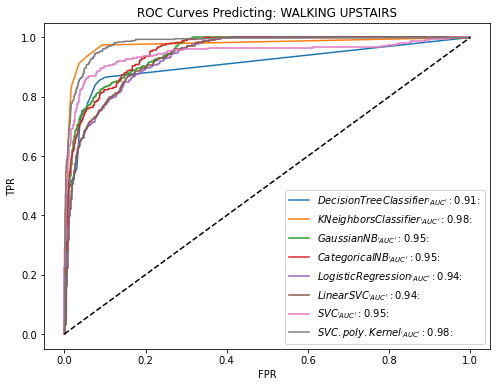

In [8]:
plt.figure(figsize=(8, 6))

#Here I used this value just to test how many records I needed to decrease performance...
#Too many values to drop, you need to get to only 30 records to have some substantial movements in the ROC curves
#reduce_training_set = np.random.RandomState(42).randint(0, high=len(rdf_train_val), size=30)

def plt_classifiers(clf, target_class, X_train, X_test, y_train, y_test, X_train_cat = None, X_test_cat = None):
    clf_name = str(clf)[:str(clf).find('(')]
    if clf_name == 'CategoricalNB':
        X_train, X_test = X_train_cat[:], X_test_cat[:]
    elif clf_name == 'SVC' and 'rbf' in str(clf):
        clf_name = 'SVC.rbf.Kernel'
    elif clf_name == 'SVC' and 'poly' in str(clf):
        clf_name = 'SVC.poly.Kernel'
    print('{}: {}'.format(clf_name, target_class))

    clf.fit(X_train, y_train)        
    y_pred = clf.predict(X_test)

    try:
        y_score = clf.predict_proba(X_test)
    except:
        y_score = clf._predict_proba_lr(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    print('ROC AUC {}'.format(roc_auc))
    print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
    print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
    print(classification_report(y_test, y_pred))
    
    cross_scores = cross_val_score(clf, np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)), cv=5, scoring='f1')
    print('F1 Score {:.3f} +/- {:.3f}'.format(np.mean(cross_scores), np.std(cross_scores)), '\n')
    plt.plot(fpr, tpr, label='${clf}_{auc}: {roc_auc:.2f}$: '.format(clf=clf_name, auc = {'AUC'}, roc_auc = roc_auc))

    if clf_name == 'DecisionTreeClassifier':
        return [roc_auc, clf.feature_importances_]

    return [roc_auc]

for clf in classifiers:
    plt_classifiers(clf, target_class, X_train, X_test, y_train, y_test, X_train_cat, X_test_cat)

plt.plot([0,1], [0,1], 'k--') 
plt.title("ROC Curves Predicting: {}".format(str(target_class).replace('_', ' ')))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()
plt.show()

Here I wasn't sure about _predict_proba_lr and I tested the correspondence at the default threshold

In [9]:
testing_correspondence_log_reg = []
for x in log_reg._predict_proba_lr(X_test)[:,1]:
    if x >= 0.5:
        testing_correspondence_log_reg.append(1)
    else:
        testing_correspondence_log_reg.append(0)

sum(testing_correspondence_log_reg) == log_reg.predict(X_test).sum()

True

I checked also for the linear Support Vector Classifier

In [10]:
testing_correspondence_lin_svc = []
for x in lin_svc._predict_proba_lr(X_test)[:,1]:
    if x >= 0.5:
        testing_correspondence_lin_svc.append(1)
    else:
        testing_correspondence_lin_svc.append(0)

sum(testing_correspondence_lin_svc) == lin_svc.predict(X_test).sum()

True

In [11]:
decision_function = lin_svc.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
lin_svc.__dict__

{'C': 0.1,
 'class_weight': None,
 'classes_': array([False,  True]),
 'coef_': array([[ 0.40697983, -2.21871858,  0.42838   , -0.86069685, -1.54247263,
          0.59548213,  0.68633845,  1.74013522, -1.36047684,  0.23157672,
         -0.49254138,  1.30993599]]),
 'dual': True,
 'fit_intercept': True,
 'intercept_': array([-2.55882856]),
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'n_features_in_': 12,
 'n_iter_': 28,
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

Here I tinkered with the C parameter of the linear SVC (I reduced the dimensionality of the dataset to two features to have immediate results, and visually understandable ones)

In [12]:
X, y = X_train[:,[0,4]], y_train
name_x = features_to_keep[0]
name_y = features_to_keep[4]

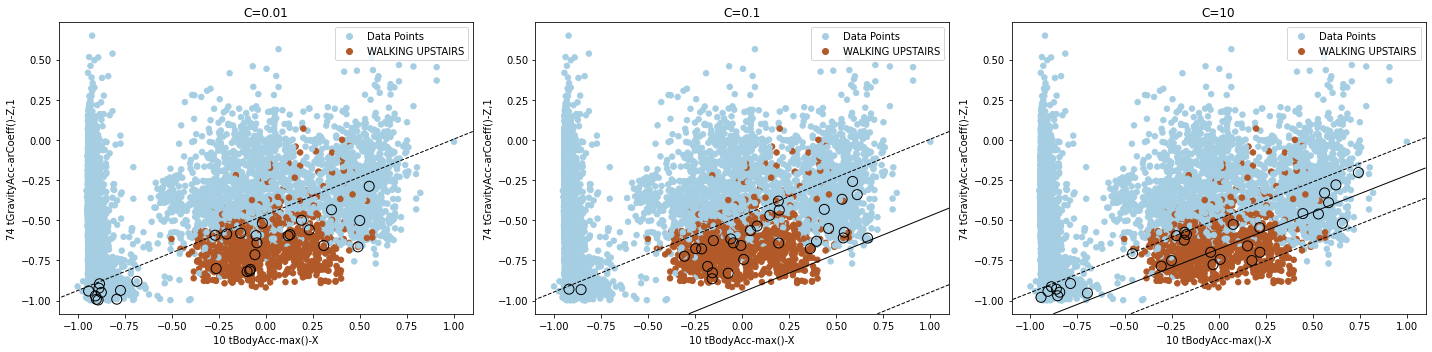

In [13]:
plt.figure(figsize=(20, 5))
for i, C in enumerate([0.01, 0.1, 10]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", max_iter=2000, random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 3, i + 1)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 2), np.linspace(ylim[0], ylim[1], 2)
    )
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(
        xx,
        yy,
        Z,
        colors="k",
        levels=[-1, 0, 1],
        alpha=1,
        linestyles=["--", "-", "--"], linewidths=[1, 1, 1]
    )
    idx = np.array(list(np.random.RandomState(42).randint(0, high=len(support_vectors[:,0]), size=30)))
    plt.scatter(
        support_vectors[:, 0][idx],
        support_vectors[:, 1][idx],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("C=" + str(C))
    plt.xlabel(name_x)
    plt.ylabel(name_y)
    legend = plt.legend(*scatter.legend_elements(), loc='upper right')
    legend.get_texts()[0].set_text('Data Points')
    legend.get_texts()[1].set_text(str(target_class).replace('_', ' '))
plt.tight_layout()
plt.show()

In [14]:
X_train, y_train = rdf_train_val[:,[0,4]], rdf_train['label'] == 'WALKING_UPSTAIRS'
X_test, y_test = rdf_test_val[:,[0,4]], rdf_test['label'] == 'WALKING_UPSTAIRS'

name_x = features_to_keep[0]
name_y = features_to_keep[4]

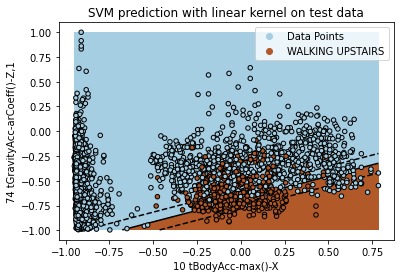

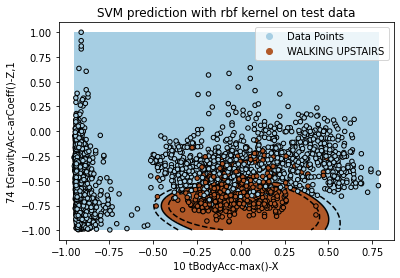

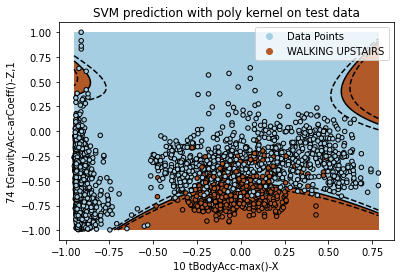

In [15]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    
    scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    plt.axis('tight')
    x_min = X_test[:, 0].min()
    x_max = X_test[:, 0].max()
    y_min = X_test[:, 1].min()
    y_max = X_test[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title('SVM prediction with {} kernel on test data'.format(kernel))
    plt.xlabel(name_x)
    plt.ylabel(name_y)
    legend = plt.legend(*scatter.legend_elements(), loc='upper right')
    legend.get_texts()[0].set_text('Data Points')
    legend.get_texts()[1].set_text(str(target_class).replace('_', ' '))
plt.show()

ROC AUC 0.6428571428571428
Accuracy 0.7333333333333333
F1-score [0.6 0.8]
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.67      1.00      0.80         8

    accuracy                           0.73        15
   macro avg       0.83      0.71      0.70        15
weighted avg       0.82      0.73      0.71        15



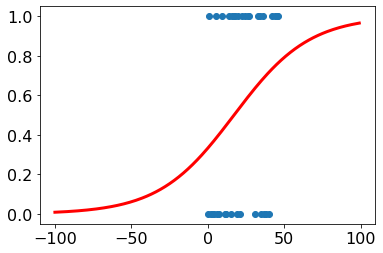

In [16]:
#creating custom random data, such that I understand how it behaves in presence of no clear pattern
X = np.arange(50).reshape(-1, 1)
y = np.random.RandomState(42).randint(0, high=2, size=50)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

plt.scatter(X_train, y_train)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_score = log_reg._predict_proba_lr(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC AUC {}'.format(roc_auc))
print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
print(classification_report(y_test, y_pred))


#using np.arange as otherwise only a fraction of the sigmoid would be plotted
loss = expit(np.arange(-100,100, 1) * log_reg.coef_ + log_reg.intercept_).ravel()
plt.plot(np.arange(-100,100, 1), loss, color='red', linewidth=3)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

ROC AUC 0.9022188379997873
Accuracy 0.8456057007125891
F1-score [0.91468217 0.18894831]
              precision    recall  f1-score   support

       False       0.85      0.99      0.91      2476
        True       0.59      0.11      0.19       471

    accuracy                           0.85      2947
   macro avg       0.72      0.55      0.55      2947
weighted avg       0.81      0.85      0.80      2947



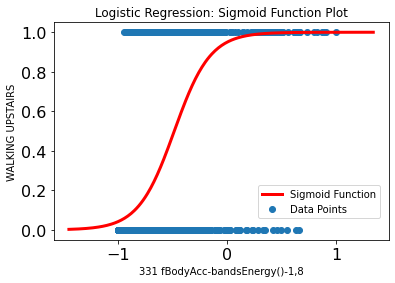

In [17]:


feat_idx_col = 7 #I tested multiple features, I plotted the one with the curvatures inside the range -1, +1

X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train, y_test = (rdf_train[target_var] == target_class).values, (rdf_test[target_var] == target_class).values

plt.scatter(X_train.T[feat_idx_col], y_train, label='Data Points')
plt.title('Logistic Regression: Sigmoid Function Plot')
plt.xlabel(features_to_keep[feat_idx_col])
plt.ylabel(str(target_class).replace('_', ' '))

X_train, X_test = X_train[:,feat_idx_col].reshape(-1, 1), X_test[:,feat_idx_col].reshape(-1, 1)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_score = log_reg._predict_proba_lr(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC AUC {}'.format(roc_auc))
print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
print(classification_report(y_test, y_pred))

loss = expit(np.arange(-1.45,1.35, 0.01) * log_reg.coef_ + log_reg.intercept_).ravel()
plt.plot(np.arange(-1.45,1.35, 0.01), loss, color='red', linewidth=3, label='Sigmoid Function')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(loc=(0.61,0.10))
plt.show()

X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train, y_test = (rdf_train[target_var] == target_class).values, (rdf_test[target_var] == target_class).values

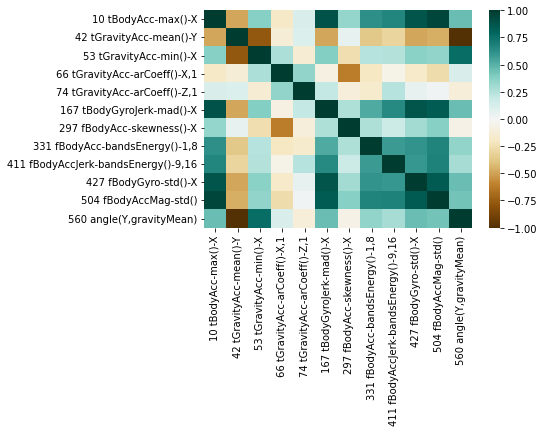

In [18]:
sns.heatmap(rdf[features_to_keep].corr(), vmin=-1, vmax=1, cmap='BrBG')

# Regression


#####################

Coefficients: [ 0.31979109  0.71795806 -0.19306515  0.51983063  0.30225116 -0.017552
 -0.33850001  0.46128465 -0.14167935 -0.37949463  0.87432601]
Intercept: 0.0488631508076825

#####################

R2: 0.395
MSE: 0.042
MAE: 0.160



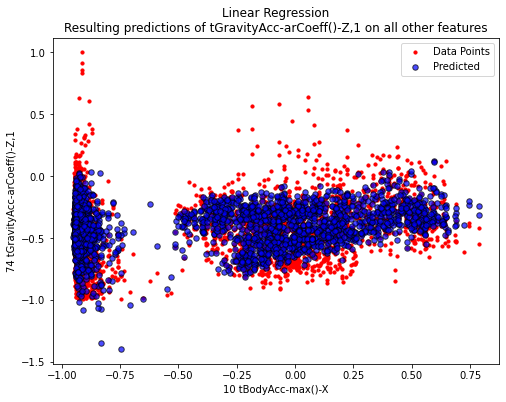

In [19]:
lin_reg = LinearRegression()
num_x = 0
num_y = 4

X_train, X_test = np.delete(rdf_train_val[:], num_y, 1), np.delete(rdf_test_val[:], num_y, 1)
y_train, y_test = rdf_train_val[:,num_y], rdf_test_val[:,num_y]

if num_y < num_x:
    num_x -= 1

lin_reg.fit(X_train, y_train)

print('\n#####################\n')
print('Coefficients:', lin_reg.coef_)
print('Intercept:', lin_reg.intercept_)
print('\n#####################\n')

y_pred = lin_reg.predict(X_test)

print('R2: {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print()

plt.figure(figsize=(8, 6))
plt.scatter(X_test[:,num_x], y_test,  color='red', s=10, alpha=1, label='Data Points')
plt.scatter(X_test[:,num_x], y_pred, edgecolor='black', color='blue', alpha=0.7, s=30, label='Predicted')
plt.xlabel(features_to_keep[num_x])
plt.ylabel(features_to_keep[num_y])
plt.title('Linear Regression\nResulting predictions of {} on all other features'.format(features_to_keep[num_y][3:]))
plt.legend()
plt.show()

In [20]:
linregpred = y_pred[:]


#####################

Coefficients: [ 0.3158892   0.59397296 -0.19125065  0.51900626  0.29780642 -0.01512658
 -0.34072745  0.46194816 -0.1409525  -0.37497325  0.72021709]
Intercept: 0.05506087289552719

#####################

R2: 0.398
MSE: 0.042
MAE: 0.159



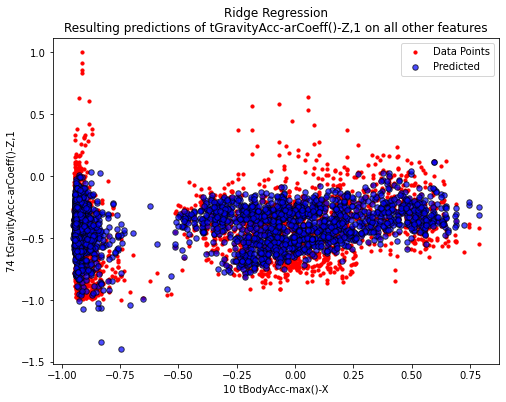

In [21]:
rid_reg = Ridge()
num_x = 0
num_y = 4

X_train, X_test = np.delete(rdf_train_val[:], num_y, 1), np.delete(rdf_test_val[:], num_y, 1)
y_train, y_test = rdf_train_val[:,num_y], rdf_test_val[:,num_y]

if num_y < num_x:
    num_x -= 1

rid_reg.fit(X_train, y_train)

print('\n#####################\n')
print('Coefficients:', rid_reg.coef_)
print('Intercept:', rid_reg.intercept_)
print('\n#####################\n')

y_pred = rid_reg.predict(X_test)

print('R2: {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print()

plt.figure(figsize=(8, 6))
plt.scatter(X_test[:,num_x], y_test,  color='red', s=10, alpha=1, label='Data Points')
plt.scatter(X_test[:,num_x], y_pred, edgecolor='black', color='blue', alpha=0.7, s=30, label='Predicted')
plt.xlabel(features_to_keep[num_x])
plt.ylabel(features_to_keep[num_y])
plt.title('Ridge Regression\nResulting predictions of {} on all other features'.format(features_to_keep[num_y][3:]))
plt.legend()
plt.show()

In [22]:
ridregpred = y_pred[:]

In [23]:
print(len(linregpred), len(ridregpred))

2947 2947


In [24]:
sum(linregpred == ridregpred)

0


#####################

Coefficients: [ 0.  0. -0.  0.  0. -0. -0.  0.  0.  0. -0.]
Intercept: -0.43102832621968834

#####################

R2: -0.002
MSE: 0.070
MAE: 0.211



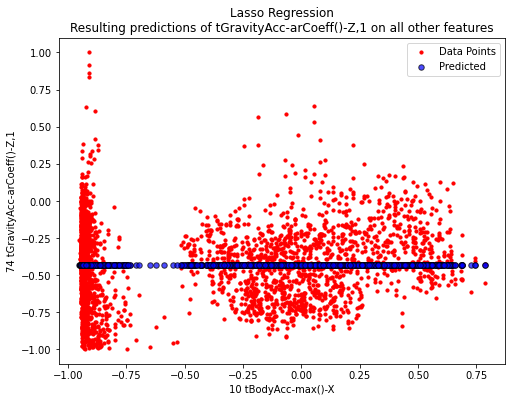

In [25]:
las_reg = Lasso()
num_x = 0
num_y = 4

X_train, X_test = np.delete(rdf_train_val[:], num_y, 1), np.delete(rdf_test_val[:], num_y, 1)
y_train, y_test = rdf_train_val[:,num_y], rdf_test_val[:,num_y]

if num_y < num_x:
    num_x -= 1

las_reg.fit(X_train, y_train)

print('\n#####################\n')
print('Coefficients:', las_reg.coef_)
print('Intercept:', las_reg.intercept_)
print('\n#####################\n')

y_pred = las_reg.predict(X_test)

print('R2: {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print()

plt.figure(figsize=(8, 6))
plt.scatter(X_test[:,num_x], y_test,  color='red', s=10, alpha=1, label='Data Points')
plt.scatter(X_test[:,num_x], y_pred, edgecolor='black', color='blue', alpha=0.7, s=30, label='Predicted')
plt.xlabel(features_to_keep[num_x])
plt.ylabel(features_to_keep[num_y])
plt.title('Lasso Regression\nResulting predictions of {} on all other features'.format(features_to_keep[num_y][3:]))
plt.legend()
plt.show()

In [26]:
#UNIVARIATE

In [27]:
X_train, X_test = rdf_train_val[:,num_x].reshape(-1, 1), rdf_test_val[:,num_x].reshape(-1, 1)
y_train, y_test = rdf_train_val[:,num_y].reshape(-1, 1), rdf_test_val[:,num_y].reshape(-1, 1)

lin_reg.fit(X_train, y_train)

print('\n#####################\n')
print('Coefficients:', lin_reg.coef_)
print('Intercept:', lin_reg.intercept_)
print('\n#####################\n')

y_pred = lin_reg.predict(X_test)

print('R2: {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print()


#####################

Coefficients: [[0.05989773]]
Intercept: [-0.40296034]

#####################

R2: 0.010
MSE: 0.069
MAE: 0.211



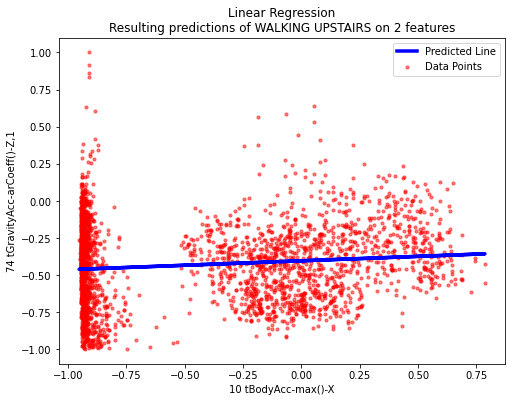

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test,  color='red', s=10, alpha=0.5, label='Data Points')
plt.plot(X_test, y_pred, color='blue', linewidth=3.5, label='Predicted Line')
plt.xlabel(features_to_keep[num_x])
plt.ylabel(features_to_keep[num_y])
plt.title('Linear Regression\nResulting predictions of {} on 2 features'.format(str(target_class).replace('_',' ')))
plt.legend()
plt.show()

In [29]:
X_train, X_test = rdf_train_val[:,num_x].reshape(-1, 1), rdf_test_val[:,num_x].reshape(-1, 1)
y_train, y_test = rdf_train_val[:,num_y].reshape(-1, 1), rdf_test_val[:,num_y].reshape(-1, 1)

rid_reg.fit(X_train, y_train)

print('\n#####################\n')
print('Coefficients:', rid_reg.coef_)
print('Intercept:', rid_reg.intercept_)
print('\n#####################\n')

y_pred = rid_reg.predict(X_test)

print('R2: {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print()


#####################

Coefficients: [[0.05987025]]
Intercept: [-0.40297322]

#####################

R2: 0.010
MSE: 0.069
MAE: 0.211



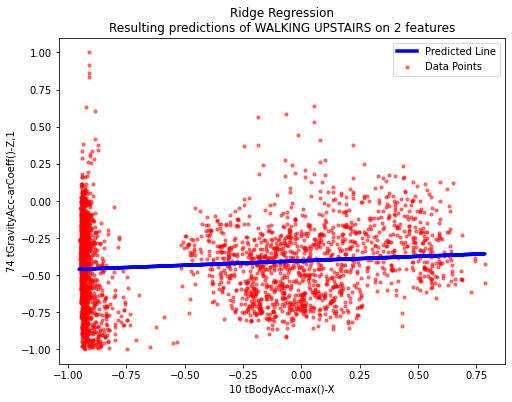

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test,  color='red', s=10, alpha=0.5, label='Data Points')
plt.plot(X_test, y_pred, color='blue', linewidth=3.5, label='Predicted Line')
plt.xlabel(features_to_keep[num_x])
plt.ylabel(features_to_keep[num_y])
plt.title('Ridge Regression\nResulting predictions of {} on 2 features'.format(str(target_class).replace('_',' ')))
plt.legend()
plt.show()

In [31]:
X_train, X_test = rdf_train_val[:,num_x].reshape(-1, 1), rdf_test_val[:,num_x].reshape(-1, 1)
y_train, y_test = rdf_train_val[:,num_y].reshape(-1, 1), rdf_test_val[:,num_y].reshape(-1, 1)

las_reg.fit(X_train, y_train)

print('\n#####################\n')
print('Coefficients:', las_reg.coef_)
print('Intercept:', las_reg.intercept_)
print('\n#####################\n')

y_pred = las_reg.predict(X_test)

print('R2: {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))
print()


#####################

Coefficients: [0.]
Intercept: [-0.43102833]

#####################

R2: -0.002
MSE: 0.070
MAE: 0.211



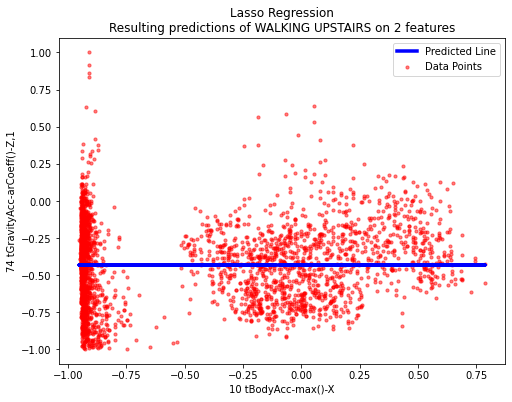

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test,  color='red', s=10, alpha=0.5, label='Data Points')
plt.plot(X_test, y_pred, color='blue', linewidth=3.5, label='Predicted Line')
plt.xlabel(features_to_keep[num_x])
plt.ylabel(features_to_keep[num_y])
plt.title('Lasso Regression\nResulting predictions of {} on 2 features'.format(str(target_class).replace('_',' ')))
plt.legend()
plt.show()

# Classification of a Subject

WARNING: Next cell will take 40 minutes

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier: 22
ROC AUC 0.8615763169617996
Accuracy 0.9702168986727097
F1-score [0.98475812 0.35211268]
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      2993
        True       0.54      0.26      0.35        96

    accuracy                           0.97      3089
   macro avg       0.76      0.63      0.67      3089
weighted avg       0.96      0.97      0.97      3089

F1 Score 0.453 +/- 0.038 

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                       random_state=42)
DecisionTreeClassifier: 7
ROC AUC 0.9060600455527991
Accuracy 0.9770152152800259
F1-score [0.98823529 0.5034965 ]
              precision    recall  f1-score   support

       False       0.98      0.99      0.99      2997
        True       0.71      0.39      0.50        92

    accuracy   

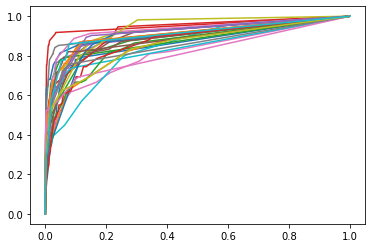

In [33]:
auc_individuals = []
X = rdf[features_to_keep].values

clf = DecisionTreeClassifier()
for target_class in rdf['individuals'].unique():
    y = rdf['individuals'] == target_class
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf = grid_search_best_estimator(clf, param_dt, cv, X_train, y_train)

    roc_auc = plt_classifiers(clf, target_class, X_train, X_test, y_train, y_test, X_train_cat, X_test_cat)[0]
    auc_individuals.append((target_class, roc_auc))
    
min_performance = sorted(auc_individuals, key=lambda x : x[1])[0]

print('Got the lowest possible performance for individual {} with an AUC of {:.2f}'.format(min_performance[0], min_performance[1]))

In [34]:
sorted(auc_individuals, key=lambda x : x[1])

[(8, 0.8147452658267965),
 (10, 0.819126579019115),
 (15, 0.839027285939451),
 (30, 0.8467062366597468),
 (26, 0.8496625572625778),
 (18, 0.8561572563265809),
 (2, 0.8569265957524796),
 (12, 0.8598622480231652),
 (22, 0.8615763169617996),
 (13, 0.8685989942616967),
 (17, 0.8792563093167324),
 (27, 0.883205764106956),
 (3, 0.8845848349383274),
 (20, 0.886574235131152),
 (5, 0.8954449486470833),
 (1, 0.8978981445689987),
 (29, 0.9014494826991982),
 (6, 0.9043371611432939),
 (25, 0.9049320483090199),
 (7, 0.9060600455527991),
 (9, 0.9075227098482913),
 (4, 0.9106440952079599),
 (14, 0.9117164672804455),
 (24, 0.9139495798319327),
 (11, 0.9182645993741869),
 (19, 0.9198504106253182),
 (23, 0.922412603771774),
 (16, 0.9308797949281333),
 (28, 0.932430338294202),
 (21, 0.953826794189638)]

In [35]:
dt_clf = DecisionTreeClassifier()
knn_clf = KNeighborsClassifier()
gnb_clf = GaussianNB()
cnb_clf = CategoricalNB()
log_reg = LogisticRegression(random_state=42)
lin_svc = LinearSVC(C=0.001, random_state=42)
svc_rbf = SVC(gamma='auto', C=0.1, kernel='rbf', random_state=42, probability=True)
svc_pol = SVC(gamma=10, kernel='poly', random_state=42, probability=True)

classifiers = [dt_clf, knn_clf, gnb_clf, cnb_clf, log_reg, lin_svc, svc_rbf, svc_pol]

WARNING: Next cell will take 10 minutes

In [36]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

target_var = 'individuals'
target_class = min_performance[0]

X = rdf[features_to_keep].values
y = rdf[target_var] == target_class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
idx_train, idx_test = y_train.reset_index().index, y_test.reset_index().index
y_train, y_test = y_train.values, y_test.values

cv = 5 #kfold of cross validation
param_dt = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'criterion' : ['gini', 'entropy'], 
              'max_depth' : [2,4,6,8,10,12, None],
              'random_state' : [42]}
param_knn = {'n_neighbors': [2,5,10,15,20]}
param_advanced = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state' : [42]}

dt_clf = grid_search_best_estimator(dt_clf, param_dt, cv, X_train, y_train)
knn_clf = grid_search_best_estimator(knn_clf, param_knn, cv, X_train, y_train)
log_reg = grid_search_best_estimator(log_reg, param_advanced, cv, X_train, y_train)
lin_svc = grid_search_best_estimator(lin_svc, param_advanced, cv, X_train, y_train)

param_advanced['gamma'] = ['auto', 10]
param_advanced['probability'] = [True]
param_advanced['kernel'] = ['rbf']
svc_rbf = grid_search_best_estimator(svc_rbf, param_advanced, cv, X_train, y_train)

param_advanced['kernel'] = ['poly']
svc_pol = grid_search_best_estimator(svc_pol, param_advanced, cv, X_train, y_train)
        
classifiers = [dt_clf, knn_clf, gnb_clf, cnb_clf, log_reg, lin_svc, svc_rbf, svc_pol]

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, random_state=42)
KNeighborsClassifier()
LogisticRegression(C=100, random_state=42)
LinearSVC(C=10, random_state=42)
SVC(C=1, gamma=10, probability=True, random_state=42)
SVC(C=0.001, gamma=10, kernel='poly', probability=True, random_state=42)


DecisionTreeClassifier: 8
ROC AUC 0.849633547262499
Accuracy 0.7733894464227905
F1-score [0.86930545 0.14841849]
              precision    recall  f1-score   support

       False       0.99      0.77      0.87      3005
        True       0.08      0.73      0.15        84

    accuracy                           0.77      3089
   macro avg       0.54      0.75      0.51      3089
weighted avg       0.97      0.77      0.85      3089

F1 Score 0.512 +/- 0.076 

KNeighborsClassifier: 8
ROC AUC 0.8437405910783615
Accuracy 0.6422790547102623
F1-score [0.77572559 0.11670663]
              precision    recall  f1-score   support

       False       0.99      0.64      0.78      3005
        True       0.06      0.87      0.12        84

    accuracy                           0.64      3089
   macro avg       0.53      0.75      0.45      3089
weighted avg       0.97      0.64      0.76      3089

F1 Score 0.500 +/- 0.072 

GaussianNB: 8
ROC AUC 0.6274463196260202
Accuracy 0.660731628358692

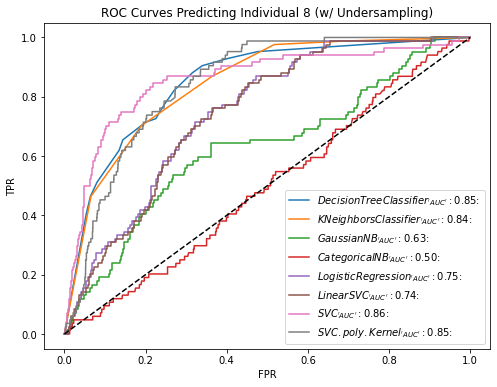

In [37]:
target_var = 'individuals'
target_class = min_performance[0]

plt.figure(figsize=(8, 6))

#Here I used this value just to test how many records I needed to decrease performance...
#Too many values to drop, you need to get to only 30 records to have some substantial movements in the ROC curves
#reduce_training_set = np.random.RandomState(42).randint(0, high=len(rdf_train_val), size=30)

for clf in classifiers:
    clf_name = str(clf)[:str(clf).find('(')]
    if clf_name == 'DecisionTreeClassifier':
        dt_feature_importances = plt_classifiers(clf, target_class, X_train, X_test, y_train, y_test, X_train_cat, X_test_cat)[1]
    elif clf_name == 'CategoricalNB':
        X_cat = list()
        for i in range(X.shape[1]):
            X_cat.append(pd.qcut(X[:, i], q=[0.0, 0.25, 0.5, 0.75, 1.0], labels=False))
        X_cat = np.array(X_cat).T
        
        X_train_cat, X_test_cat = X_cat[idx_train], X_cat[idx_test]
        
        plt_classifiers(clf, target_class, X_train, X_test, y_train, y_test, X_train_cat, X_test_cat)
    else:
        plt_classifiers(clf, target_class, X_train, X_test, y_train, y_test, X_train_cat, X_test_cat)
    
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves Predicting Individual {} (w/ Undersampling)".format(str(target_class).replace('_', ' ')))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()
plt.show()

In [38]:
#Here I wasn't sure about _predict_proba_lr and I tested the correspondence at the default threshold
testing_correspondence_log_reg = []
for x in log_reg._predict_proba_lr(X_test)[:,1]:
    if x >= 0.5:
        testing_correspondence_log_reg.append(1)
    else:
        testing_correspondence_log_reg.append(0)

sum(testing_correspondence_log_reg) == log_reg.predict(X_test).sum()

True

In [39]:
testing_correspondence_lin_svc = []
for x in lin_svc._predict_proba_lr(X_test)[:,1]:
    if x >= 0.5:
        testing_correspondence_lin_svc.append(1)
    else:
        testing_correspondence_lin_svc.append(0)

sum(testing_correspondence_lin_svc) == lin_svc.predict(X_test).sum()

True

In [40]:
best_explaining_feat = max([(x, y) for x, y in zip(dt_clf.feature_importances_, [(n, el) for n, el in enumerate(features_to_keep)])])
best_explaining_feat

(0.2899838107709887, (2, '53 tGravityAcc-min()-X'))

ROC AUC 0.5398819427937565
Accuracy 0.9728067335707349
F1-score [0.98621595 0.        ]
              precision    recall  f1-score   support

       False       0.97      1.00      0.99      3005
        True       0.00      0.00      0.00        84

    accuracy                           0.97      3089
   macro avg       0.49      0.50      0.49      3089
weighted avg       0.95      0.97      0.96      3089



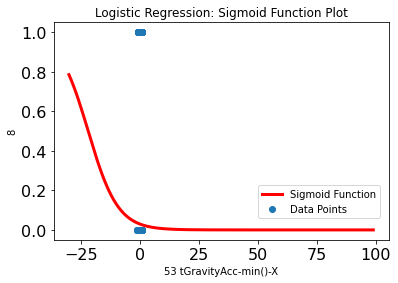

In [41]:
feat_idx_col = best_explaining_feat[1][0]

X = rdf[features_to_keep].values
y = (rdf[target_var] == target_class)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

plt.scatter(X_train.T[feat_idx_col], y_train, label='Data Points')
plt.title('Logistic Regression: Sigmoid Function Plot')
plt.xlabel(features_to_keep[feat_idx_col])
plt.ylabel(str(target_class).replace('_', ' '))

X_train, X_test = X_train[:,feat_idx_col].reshape(-1, 1), X_test[:,feat_idx_col].reshape(-1, 1)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_score = log_reg._predict_proba_lr(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC AUC {}'.format(roc_auc))
print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
print(classification_report(y_test, y_pred))

loss = expit(np.arange(-30,100, 1) * log_reg.coef_ + log_reg.intercept_).ravel()
plt.plot(np.arange(-30,100, 1), loss, color='red', linewidth=3, label='Sigmoid Function')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(loc=(0.61,0.10))
plt.show()

X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train, y_test = (rdf_train[target_var] == target_class).values, (rdf_test[target_var] == target_class).values

In [42]:
sum(rdf['individuals'] == min_performance[0])

280

In [43]:
target_var = 'individuals'
target_class = min_performance[0]

#Here I used this value just to test how many records I needed to decrease performance...
#Too many values to drop, you need to get to only 30 records to have some substantial movements in the ROC curves
#reduce_training_set = np.random.RandomState(42).randint(0, high=len(rdf_train_val), size=30)

X = rdf[features_to_keep].values
y = rdf[target_var] == target_class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(len(X_train))
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
    

7206


In [44]:
sum(y_train)/len(rdf[features_to_keep].values)

0.019038368139873724

In [45]:
sum(y_train)/(len(rdf[features_to_keep].values)*0.7)

0.02719766877124818

In [46]:
sum(y_train)

196

In [47]:
len(X_train)

392

I didn't use the polynomial kernel as it took too much time to compute with the oversampled dataset

WARNING: Next cell will take 35 minutes

In [48]:
target_var = 'individuals'
target_class = min_performance[0]

X = rdf[features_to_keep].values
y = rdf[target_var] == target_class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

idx_train, idx_test = y_train.reset_index().index, y_test.reset_index().index
y_train, y_test = y_train.values, y_test.values

cv = 5 #kfold of cross validation
param_dt = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'criterion' : ['gini', 'entropy'], 
              'max_depth' : [2,4,6,8,10,12, None],
              'random_state' : [42]}
param_knn = {'n_neighbors': [2,5,10,15,20]}
param_advanced = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state' : [42]}

dt_clf = grid_search_best_estimator(dt_clf, param_dt, cv, X_train, y_train)
knn_clf = grid_search_best_estimator(knn_clf, param_knn, cv, X_train, y_train)
log_reg = grid_search_best_estimator(log_reg, param_advanced, cv, X_train, y_train)
lin_svc = grid_search_best_estimator(lin_svc, param_advanced, cv, X_train, y_train)

param_advanced['gamma'] = ['auto', 10]
param_advanced['probability'] = [True]
param_advanced['kernel'] = ['rbf']
svc_rbf = grid_search_best_estimator(svc_rbf, param_advanced, cv, X_train, y_train)

#skip it to avoid computing hours of not so relevant results
#param_advanced['kernel'] = ['poly']
#svc_pol = grid_search_best_estimator(svc_pol, param_advanced, cv, X_train, y_train)
        
classifiers = [dt_clf, knn_clf, gnb_clf, cnb_clf, log_reg, lin_svc, svc_rbf]

DecisionTreeClassifier(criterion='entropy', random_state=42)
KNeighborsClassifier(n_neighbors=10)
LogisticRegression(C=10, random_state=42)
LinearSVC(C=1, random_state=42)
SVC(C=100, gamma=10, probability=True, random_state=42)


DecisionTreeClassifier: 8
ROC AUC 0.7446755407653909
Accuracy 0.9760440271932664
F1-score [0.98770764 0.53164557]
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      3005
        True       0.57      0.50      0.53        84

    accuracy                           0.98      3089
   macro avg       0.78      0.74      0.76      3089
weighted avg       0.97      0.98      0.98      3089

F1 Score 0.987 +/- 0.004 

KNeighborsClassifier: 8
ROC AUC 0.8814535298312336
Accuracy 0.9326642926513434
F1-score [0.96440794 0.37724551]
              precision    recall  f1-score   support

       False       0.99      0.94      0.96      3005
        True       0.25      0.75      0.38        84

    accuracy                           0.93      3089
   macro avg       0.62      0.84      0.67      3089
weighted avg       0.97      0.93      0.95      3089

F1 Score 0.959 +/- 0.003 

GaussianNB: 8
ROC AUC 0.5990888202202678
Accuracy 0.72224020718679

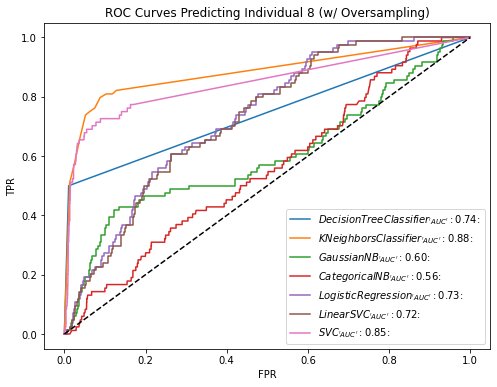

In [49]:
plt.figure(figsize=(8, 6))

#Here I used this value just to test how many records I needed to decrease performance...
#Too many values to drop, you need to get to only 30 records to have some substantial movements in the ROC curves
#reduce_training_set = np.random.RandomState(42).randint(0, high=len(rdf_train_val), size=30)

X = rdf[features_to_keep].values
y = rdf[target_var] == target_class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

idx_train, idx_test = y_train.reset_index().index, y_test.reset_index().index
y_train, y_test = y_train.values, y_test.values

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

for clf in classifiers:
    clf_name = str(clf)[:str(clf).find('(')]
    if clf_name == 'CategoricalNB':
        X_cat = list()
        for i in range(X.shape[1]):
            X_cat.append(pd.qcut(X[:, i], q=[0.0, 0.25, 0.5, 0.75, 1.0], labels=False))
        X_cat = np.array(X_cat).T
        
        X_train_cat, X_test_cat = X_cat[idx_train], X_cat[idx_test]

    plt_classifiers(clf, target_class, X_train, X_test, y_train, y_test, X_train_cat, X_test_cat)
    
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves Predicting Individual {} (w/ Oversampling)".format(str(target_class).replace('_', ' ')))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()
plt.show()

# Neural Network (Multi-layer Perceptron Classifier)

In [50]:
def train_advanced(clf, target_class, X_train, X_test, y_train, y_test, scoring = 'f1'):
    clf_name = str(clf)[:str(clf).find('(')]
    print('{}: {}'.format(clf_name, target_class))

    clf.fit(X_train, y_train)        
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    print('ROC AUC {}'.format(roc_auc))
    print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
    print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
    print(classification_report(y_test, y_pred))
    
    cross_scores = cross_val_score(clf, np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)), cv=5, scoring = scoring)
    print('{} Score {:.3f} +/- {:.3f}'.format(str(scoring).upper(), np.mean(cross_scores), np.std(cross_scores)), '\n')

    try:
        return fpr, tpr, roc_auc, clf.loss_curve_
    except:
        return fpr, tpr, roc_auc

In [51]:
def array_normalizer(loss_array, maximum_length_arr): #the input is a loss_array for which each element is ((fpr,tpr), loss_curve)
    normalized = []

    for x in loss_array:
        new_array = []
        considered = x[1]
        state = 0

        while len(new_array) < maximum_length_arr and len(considered) < maximum_length_arr:
            if state > 0:
                considered = new_array
                new_array = []
            to_add = []
            for n in range(1, len(considered)):
                to_add.append((considered[n-1]+considered[n])/2)
            count = 0
            for n in range(1, len(considered), 1):
                if count < len(to_add):
                    new_array.append(considered[n-1])
                    new_array.append(to_add[count])
                    count +=1
            state += 1
            
        if new_array == []:
            new_array = x[1]

        normalized.append(np.array(new_array))

    return normalized

In [52]:
def train_mlp(X_train, X_test, y_train, y_test):
    clf = MLPClassifier()

    #I will search only for the best parameter between constant and adaptive
    param_mlp = {'learning_rate' : ['constant', 'adaptive'], 
                  'hidden_layer_sizes': [(100,200,)], 
                  'random_state' : [42],  'max_iter' : [3000]}

    loss_array = []

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    #plotting the second window of the plot
    for activation_fun in ['identity', 'logistic', 'tanh', 'relu']:
        param_mlp['activation'] = [activation_fun]
        print('Activation Function =', activation_fun, '\n')
        #clf = grid_search_best_estimator(clf, param_mlp, 3, X_train, y_train) #with 3 kfold cv the result is always a constant learning rate

        clf = MLPClassifier(activation=activation_fun, 
                            hidden_layer_sizes=(100, 200), 
                            learning_rate='constant', 
                            max_iter=3000, random_state=42)

        fpr, tpr, roc_auc, loss_curve = train_advanced(clf, target_class, X_train, X_test, y_train, y_test)
        loss_array.append(((fpr,tpr), loss_curve))

        ax[1].plot(fpr, tpr, label='$AUC_{clf}$: {roc_auc:.2f}'.format(clf={activation_fun}, roc_auc=roc_auc))
        print('########################\n')

    ax[1].plot([0,1], [0,1], 'k--')
    ax[1].set_title('Roc Curve Plot', fontsize=20)
    ax[1].legend(fontsize=20)
    ax[1].set_xlabel('FPR', fontsize=20)
    ax[1].set_ylabel('TPR', fontsize=20)

    #plotting the first window of the plot
    maximum_length_arr = max([len(x[1]) for x in loss_array])
    normalized = array_normalizer(loss_array, maximum_length_arr)

    index_epoch = 0
    for activation_fun, x in zip(['identity', 'logistic', 'tanh', 'relu'], normalized):
        ax[0].plot(x[:maximum_length_arr], label='{}, n° of epochs: {}'.format(activation_fun, len(loss_array[index_epoch][1])))
        index_epoch += 1

    ax[0].set_title('Loss Curve Plot', fontsize=20)
    ax[0].set_xlabel('Normalized n° of Epochs', fontsize=20)
    ax[0].set_ylabel('Loss', fontsize=20)
    ax[0].set_xticks([])
    ax[0].legend(fontsize=20)

    #showing the finalized plot
    plt.suptitle('ANN Predictions of {} by Activation Function'.format(str(target_class).replace('.', ' ')), fontsize=25)
    plt.show()

    #plotting also the original plot min max scaled instead
    plt.figure(figsize=(9, 8))
    for activation_fun, loss_curve in zip(['identity', 'logistic', 'tanh', 'relu'], [x[1] for x in loss_array]):
        plt.plot((loss_curve-min(loss_curve))/(max(loss_curve)-min(loss_curve)), label='{}, original domain: [{:.2f}, {:.2f}]'.format(activation_fun, min(loss_curve), max(loss_curve)))
        plt.title('Loss Curve Plot (Min-Max Scaled)', fontsize=20)
        plt.legend(fontsize=20)
        plt.ylabel('Normalized Loss', fontsize=20)
    plt.show()

    return loss_array #always assign the function output to a variable to avoid it to be printed

WARNING: Next cell will take 20 minutes

Activation Function = identity 

MLPClassifier: WALKING_UPSTAIRS
ROC AUC 0.9305622725510978
Accuracy 0.9090600610790635
F1-score [0.94711918 0.67554479]
              precision    recall  f1-score   support

       False       0.93      0.97      0.95      2476
        True       0.79      0.59      0.68       471

    accuracy                           0.91      2947
   macro avg       0.86      0.78      0.81      2947
weighted avg       0.90      0.91      0.90      2947

F1 Score 0.774 +/- 0.080 

########################

Activation Function = logistic 

MLPClassifier: WALKING_UPSTAIRS
ROC AUC 0.9863359160895767
Accuracy 0.9514760773668137
F1-score [0.97137137 0.84093437]
              precision    recall  f1-score   support

       False       0.96      0.98      0.97      2476
        True       0.88      0.80      0.84       471

    accuracy                           0.95      2947
   macro avg       0.92      0.89      0.91      2947
weighted avg       0.95      0.95      0.9

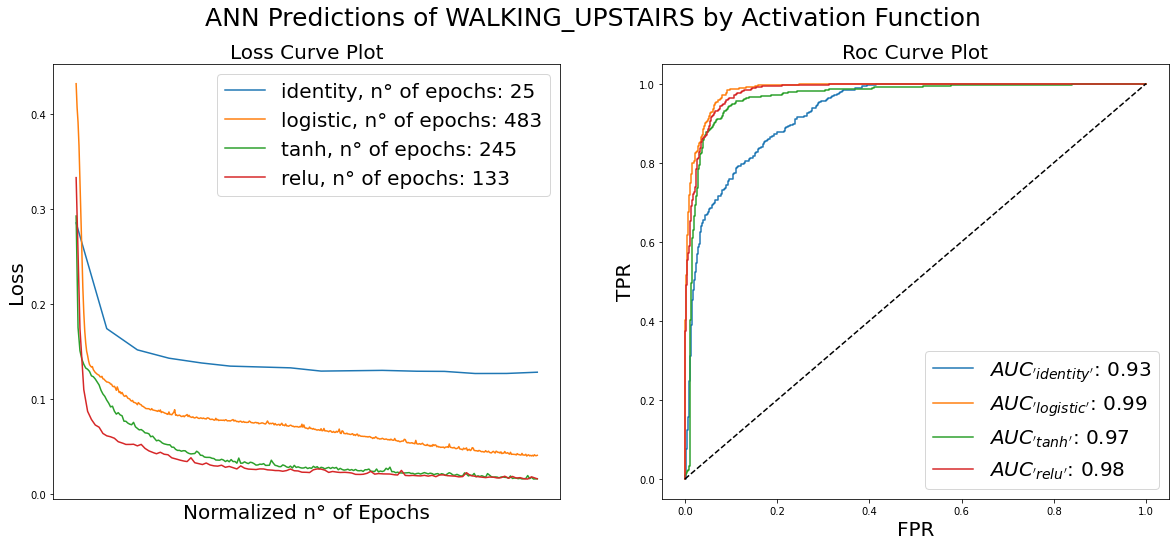

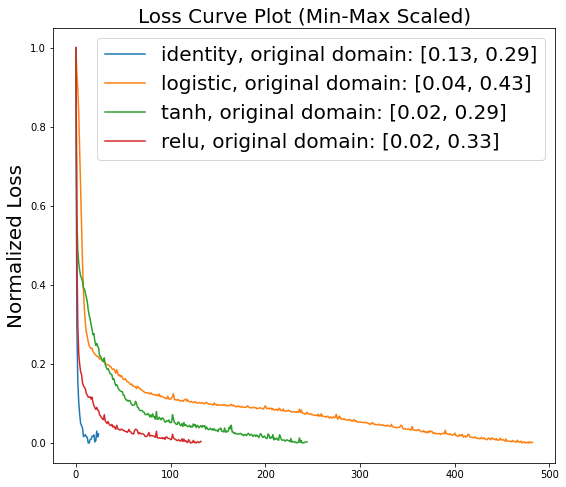

In [53]:
target_var = 'label'
target_class = 'WALKING_UPSTAIRS'
X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train, y_test = (rdf_train[target_var] == target_class).values, (rdf_test[target_var] == target_class).values

la_label = train_mlp(X_train, X_test, y_train, y_test)

WARNING: Next cell will take 15 minutes

Activation Function = identity 

MLPClassifier: 8
ROC AUC 0.7023334125663576
Accuracy 0.9724830042084817
F1-score [0.98604957 0.        ]
              precision    recall  f1-score   support

       False       0.97      1.00      0.99      3005
        True       0.00      0.00      0.00        84

    accuracy                           0.97      3089
   macro avg       0.49      0.50      0.49      3089
weighted avg       0.95      0.97      0.96      3089

F1 Score 0.000 +/- 0.000 

########################

Activation Function = logistic 

MLPClassifier: 8
ROC AUC 0.6989660090325648
Accuracy 0.9724830042084817
F1-score [0.98604957 0.        ]
              precision    recall  f1-score   support

       False       0.97      1.00      0.99      3005
        True       0.00      0.00      0.00        84

    accuracy                           0.97      3089
   macro avg       0.49      0.50      0.49      3089
weighted avg       0.95      0.97      0.96      3089

F1 Score 0.000 +/

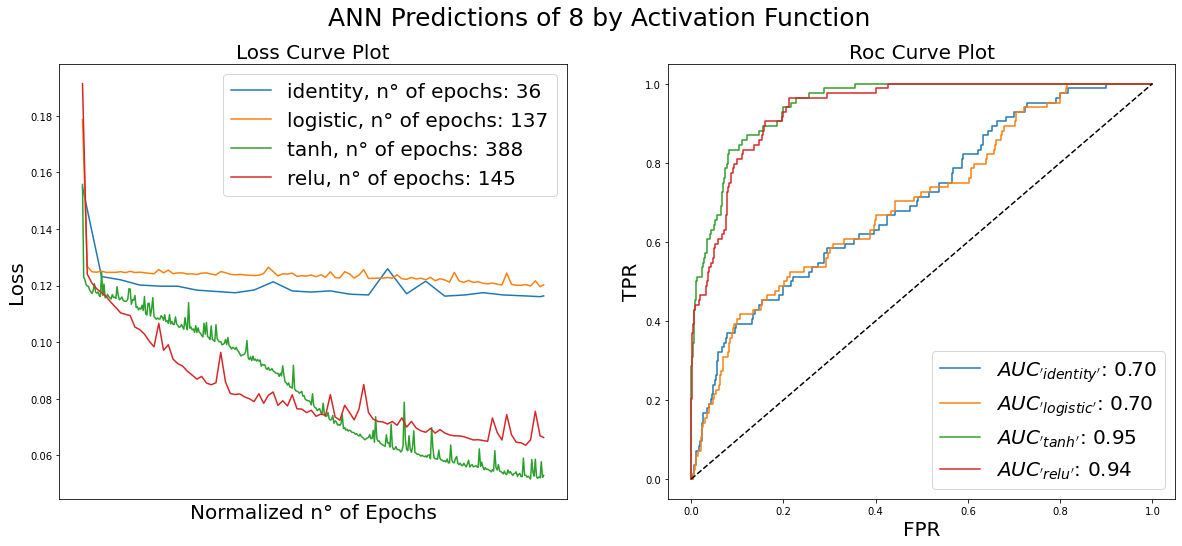

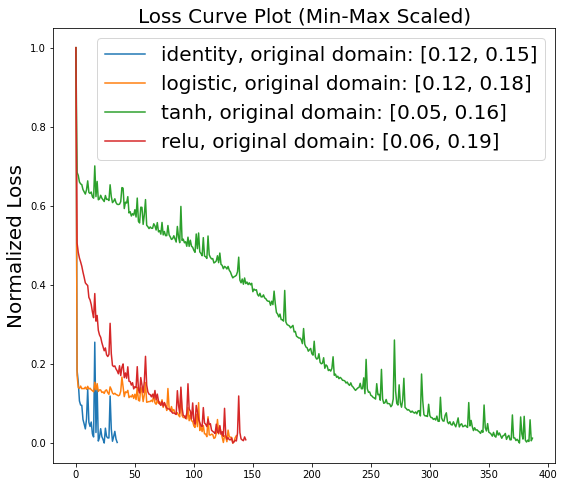

In [54]:
target_var = 'individuals'
target_class = min_performance[0]

X = rdf[features_to_keep].values
y = (rdf[target_var] == target_class).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

la_individuals = train_mlp(X_train, X_test, y_train, y_test)


WARNING: Next cell will take 5 minutes

Activation Function = identity 

MLPClassifier: 8
ROC AUC 0.7456778385230964
Accuracy 0.6685011330527679
F1-score [0.79658323 0.1048951 ]
              precision    recall  f1-score   support

       False       0.99      0.67      0.80      3005
        True       0.06      0.71      0.10        84

    accuracy                           0.67      3089
   macro avg       0.52      0.69      0.45      3089
weighted avg       0.96      0.67      0.78      3089

F1 Score 0.025 +/- 0.051 

########################

Activation Function = logistic 

MLPClassifier: 8
ROC AUC 0.742841296252278
Accuracy 0.6717384266752995
F1-score [0.79888933 0.10739437]
              precision    recall  f1-score   support

       False       0.99      0.67      0.80      3005
        True       0.06      0.73      0.11        84

    accuracy                           0.67      3089
   macro avg       0.52      0.70      0.45      3089
weighted avg       0.96      0.67      0.78      3089

F1 Score 0.000 +/-

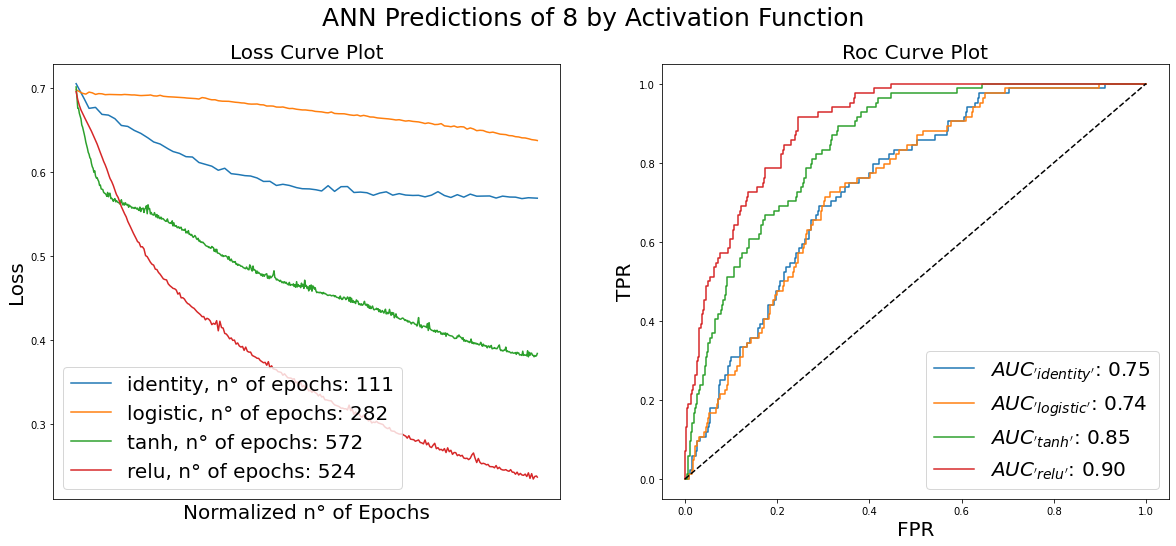

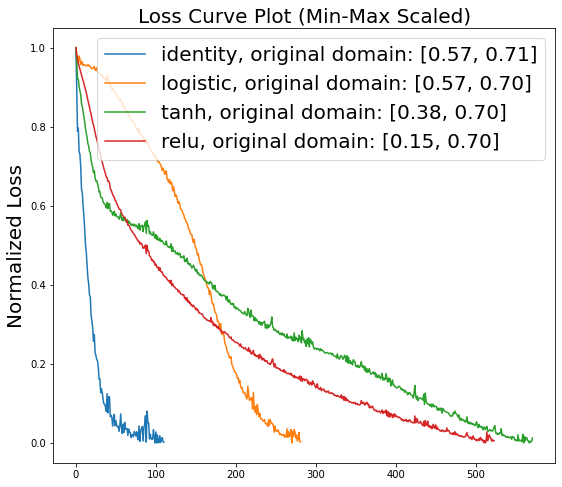

In [55]:
#WITH UNDERSAMPLING
target_var = 'individuals'
target_class = min_performance[0]

X = rdf[features_to_keep].values
y = (rdf[target_var] == target_class).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train, y_train = rus.fit_resample(X_train, y_train)

la_individuals = train_mlp(X_train, X_test, y_train, y_test)

# Ensamble Methods

In [56]:
target_var = 'label'
target_class = 'WALKING_UPSTAIRS'
X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train, y_test = (rdf_train[target_var] == target_class).values, (rdf_test[target_var] == target_class).values

param_rf = {'n_estimators' : [50,100], 'criterion' : ['gini', 'entropy'],
            'max_depth': [None]+ list(np.arange(2, 20)), 
            'min_samples_split' : [2, 5, 10, 20, 30, 50, 100], 
            'min_samples_leaf' : [1, 5, 10, 20, 30, 50, 100], 
            'min_weight_fraction_leaf' : [0], 
            'max_features' : ['auto'], 'random_state' : [42]}

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_rf, scoring='roc_auc', n_iter=20, cv=5)
random_search.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(random_search.best_estimator_)

rf_clf = random_search.best_estimator_
ada_clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, random_state=42)
bag_clf = BaggingClassifier(n_estimators=50, random_state=42, 
                            base_estimator=MLPClassifier(activation='identity', 
                                                         learning_rate = 'constant', 
                                                         hidden_layer_sizes=(100,), 
                                                         max_iter=3000, 
                                                         random_state=42))

classifiers = [bag_clf, ada_clf, rf_clf]

Best parameters set found on development set:
RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_split=20,
                       min_weight_fraction_leaf=0, random_state=42)


WARNING: Next cell will take 15 minutes

BaggingClassifier: WALKING_UPSTAIRS
ROC AUC 0.9325962359671959
Accuracy 0.9093993892093655
F1-score [0.94763679 0.66415094]
              precision    recall  f1-score   support

       False       0.92      0.98      0.95      2476
        True       0.81      0.56      0.66       471

    accuracy                           0.91      2947
   macro avg       0.87      0.77      0.81      2947
weighted avg       0.90      0.91      0.90      2947

ROC_AUC Score 0.966 +/- 0.014 

########################

AdaBoostClassifier: WALKING_UPSTAIRS
ROC AUC 0.9751679820544745
Accuracy 0.9331523583305056
F1-score [0.96062363 0.77890011]
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      2476
        True       0.83      0.74      0.78       471

    accuracy                           0.93      2947
   macro avg       0.89      0.85      0.87      2947
weighted avg       0.93      0.93      0.93      2947

ROC_AUC Score 0.991 +/- 0.006 

#######

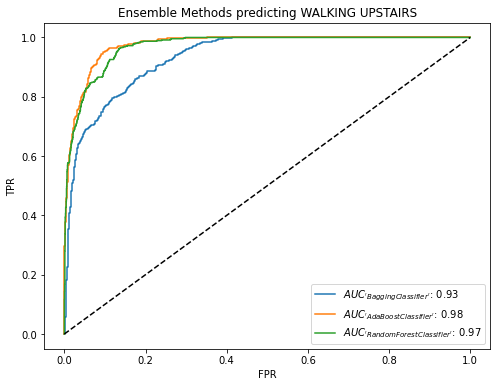

In [57]:
plt.figure(figsize=(8, 6))

for clf in classifiers:
    clf_name = str(clf)[:str(clf).find('(')]
    fpr, tpr, roc_auc = train_advanced(clf, target_class, X_train, X_test, y_train, y_test, scoring = 'roc_auc')
    plt.plot(fpr, tpr, label='$AUC_{clf}$: {roc_auc:.2f}'.format(clf={clf_name}, roc_auc=roc_auc))
    print('########################\n')
    
plt.plot([0,1], [0,1], 'k--')
plt.title('Ensemble Methods predicting {}'.format(str(target_class).replace('_', ' ')))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [58]:
tree_feature_importances = rf_clf.feature_importances_
for imp, feat in zip(tree_feature_importances, features_to_keep):
    print(imp, feat)

0.12945582406931927 10 tBodyAcc-max()-X
0.08929672346010813 42 tGravityAcc-mean()-Y
0.05207899882516674 53 tGravityAcc-min()-X
0.04713794108307559 66 tGravityAcc-arCoeff()-X,1
0.17821580649262933 74 tGravityAcc-arCoeff()-Z,1
0.08872165342041015 167 tBodyGyroJerk-mad()-X
0.01853918179281365 297 fBodyAcc-skewness()-X
0.11685403383940127 331 fBodyAcc-bandsEnergy()-1,8
0.05240424832177734 411 fBodyAccJerk-bandsEnergy()-9,16
0.03952262479760405 427 fBodyGyro-std()-X
0.09875444056218044 504 fBodyAccMag-std()
0.08901852333551405 560 angle(Y,gravityMean)


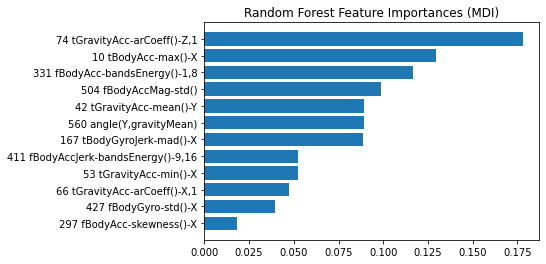

In [59]:
nbr_features = len(features_to_keep)

tree_feature_importances = rf_clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(features_to_keep)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

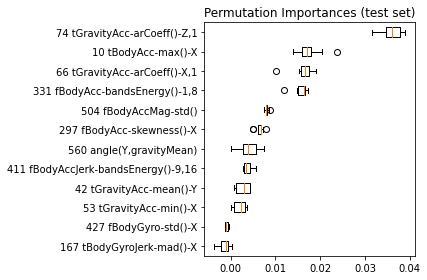

In [60]:
result = permutation_importance(rf_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features_to_keep)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

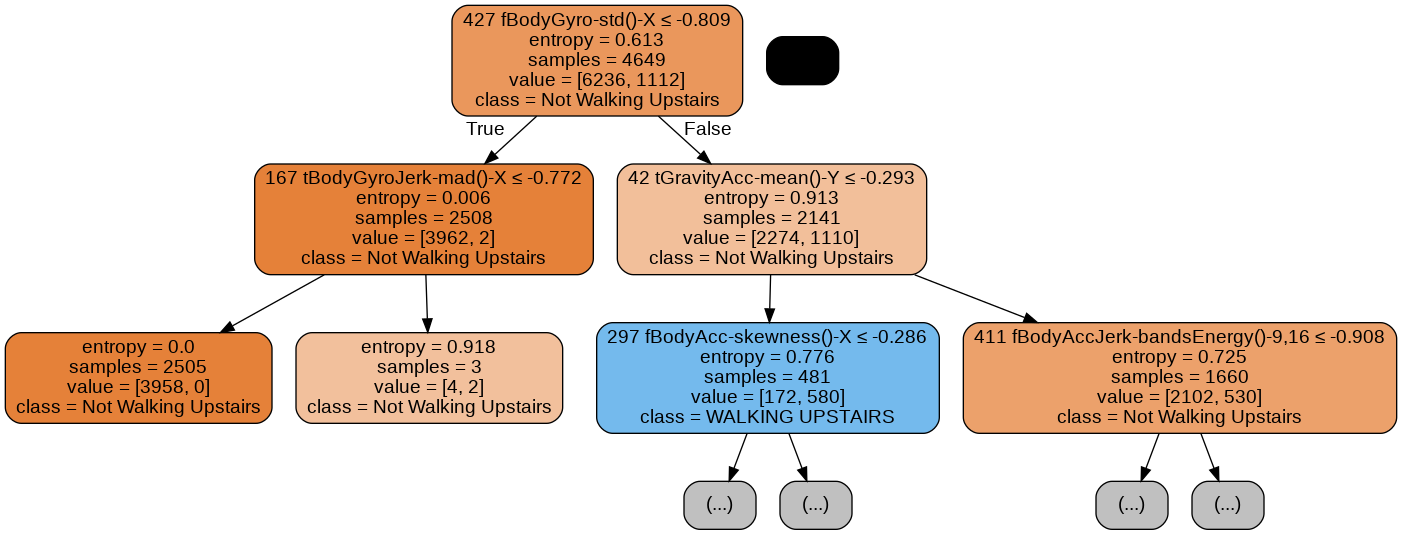

In [61]:
dot_data = tree.export_graphviz(rf_clf.estimators_[0], out_file=None,  
                                feature_names=features_to_keep, 
                                class_names=['Not Walking Upstairs', 'WALKING UPSTAIRS'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=2)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

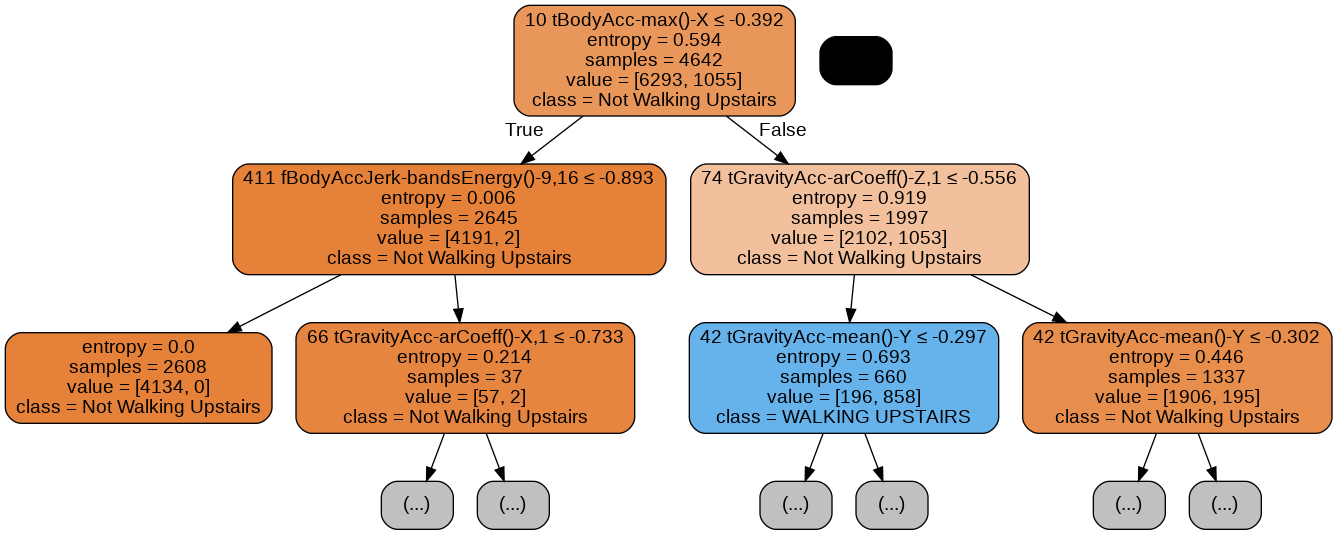

In [62]:
dot_data = tree.export_graphviz(rf_clf.estimators_[49], out_file=None,  
                                feature_names=features_to_keep, 
                                class_names=['Not Walking Upstairs', 'WALKING UPSTAIRS'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=2)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

WARNING: Next cell will take 20 minutes

Best parameters set found on development set:
RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_leaf=10,
                       min_weight_fraction_leaf=0, random_state=42)
BaggingClassifier: 8
ROC AUC 0.7181800174312654
Accuracy 0.9724830042084817
F1-score [0.98604957 0.        ]
              precision    recall  f1-score   support

       False       0.97      1.00      0.99      3005
        True       0.00      0.00      0.00        84

    accuracy                           0.97      3089
   macro avg       0.49      0.50      0.49      3089
weighted avg       0.95      0.97      0.96      3089

ROC_AUC Score 0.723 +/- 0.030 

########################

AdaBoostClassifier: 8
ROC AUC 0.8952777117502574
Accuracy 0.973130462932988
F1-score [0.98635542 0.12631579]
              precision    recall  f1-score   support

       False       0.97      1.00      0.99      3005
        True       0.55      0.07      0.13        84

    accuracy                           0

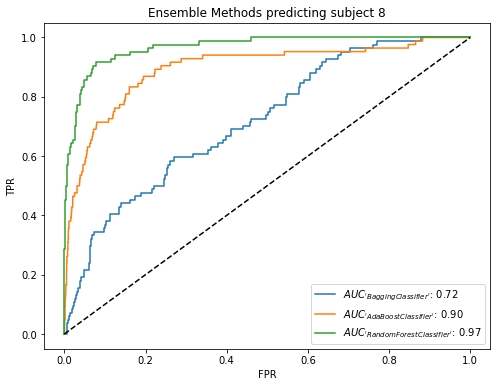

------------------Applying Undersampling------------------
Best parameters set found on development set:
RandomForestClassifier(criterion='entropy', max_depth=7,
                       min_weight_fraction_leaf=0, n_estimators=50,
                       random_state=42)
BaggingClassifier: 8
ROC AUC 0.7415894144679502
Accuracy 0.6617028164454516
F1-score [0.79137552 0.10607357]
              precision    recall  f1-score   support

       False       0.99      0.66      0.79      3005
        True       0.06      0.74      0.11        84

    accuracy                           0.66      3089
   macro avg       0.52      0.70      0.45      3089
weighted avg       0.96      0.66      0.77      3089

ROC_AUC Score 0.731 +/- 0.035 

########################

AdaBoostClassifier: 8
ROC AUC 0.8930750336740354
Accuracy 0.7989640660407898
F1-score [0.88523378 0.19035202]
              precision    recall  f1-score   support

       False       1.00      0.80      0.89      3005
        True     

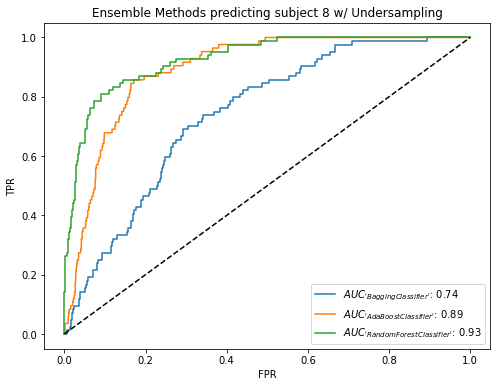

In [63]:
target_var = 'individuals'
target_class = min_performance[0]

X = rdf[features_to_keep].values
y = (rdf[target_var] == target_class).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

for description in [None, 'RUS']:
    rus_desc = ''
    if description == 'RUS':
        print('------------------Applying Undersampling------------------')
        X_train, y_train = rus.fit_resample(X_train, y_train)
        rus_desc = ' w/ Undersampling'
        
    random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_rf, scoring='roc_auc', n_iter=20, cv=5)
    random_search.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(random_search.best_estimator_)

    rf_clf = random_search.best_estimator_
    classifiers = [bag_clf, ada_clf, rf_clf]
    
    plt.figure(figsize=(8, 6))

    for clf in classifiers:
        clf_name = str(clf)[:str(clf).find('(')]
        fpr, tpr, roc_auc = train_advanced(clf, target_class, X_train, X_test, y_train, y_test, scoring = 'roc_auc')
        plt.plot(fpr, tpr, label='$AUC_{clf}$: {roc_auc:.2f}'.format(clf={clf_name}, roc_auc=roc_auc))
        print('########################\n')
        
    plt.plot([0,1], [0,1], 'k--')
    plt.title('Ensemble Methods predicting subject {}{}'.format(target_class, rus_desc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

In [64]:
tree_feature_importances = rf_clf.feature_importances_
for imp, feat in zip(tree_feature_importances, features_to_keep):
    print(imp, feat)

0.055437502883171424 10 tBodyAcc-max()-X
0.11585290041995129 42 tGravityAcc-mean()-Y
0.121053555739238 53 tGravityAcc-min()-X
0.06417343292204895 66 tGravityAcc-arCoeff()-X,1
0.038177528937408264 74 tGravityAcc-arCoeff()-Z,1
0.12286248368025877 167 tBodyGyroJerk-mad()-X
0.05371083368028989 297 fBodyAcc-skewness()-X
0.1277298939734037 331 fBodyAcc-bandsEnergy()-1,8
0.06476548550003068 411 fBodyAccJerk-bandsEnergy()-9,16
0.08530908608263371 427 fBodyGyro-std()-X
0.04545418386991003 504 fBodyAccMag-std()
0.10547311231165525 560 angle(Y,gravityMean)


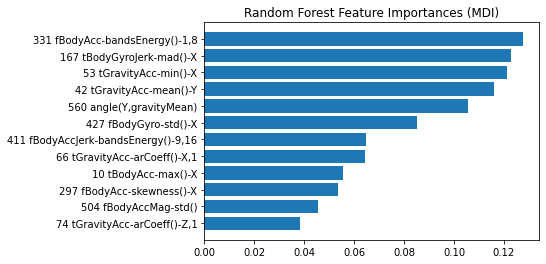

In [65]:
nbr_features = len(features_to_keep)

tree_feature_importances = rf_clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(features_to_keep)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

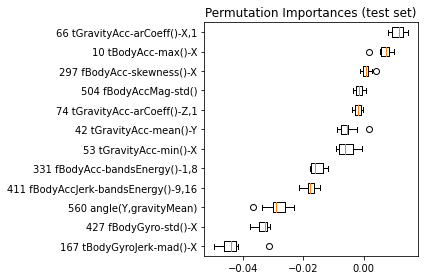

In [66]:
result = permutation_importance(rf_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features_to_keep)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

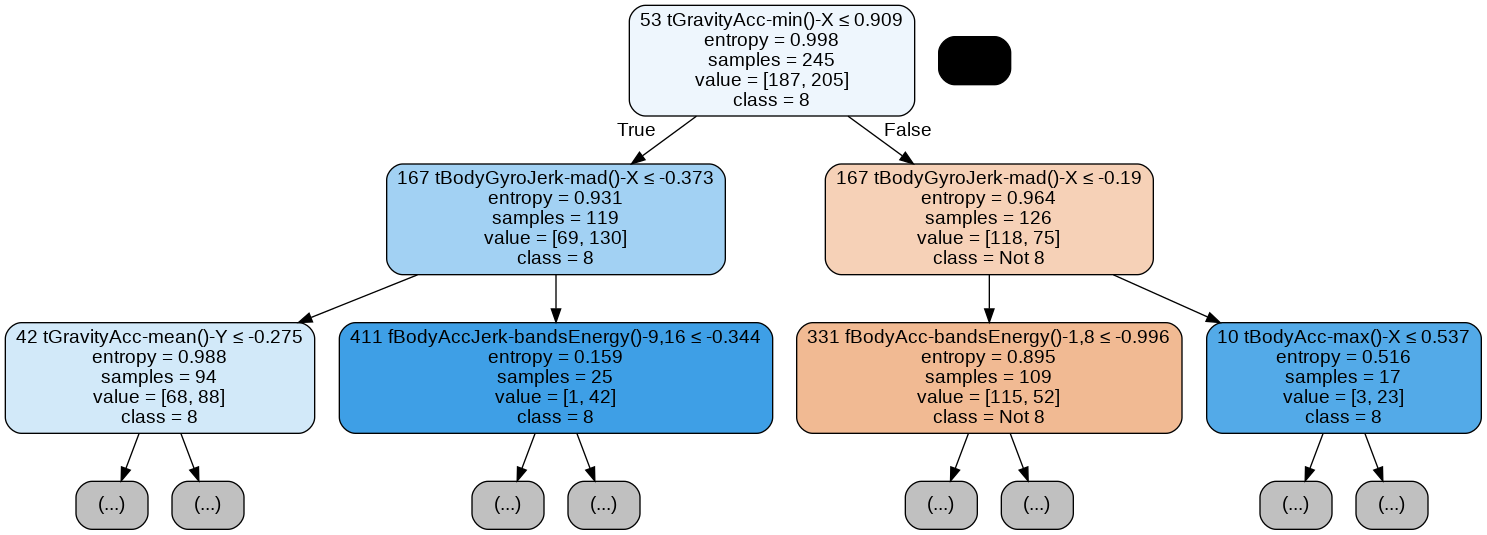

In [67]:
dot_data = tree.export_graphviz(rf_clf.estimators_[0], out_file=None,  
                                feature_names=features_to_keep, 
                                class_names=['Not {}'.format(target_class), str(target_class)],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=2)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

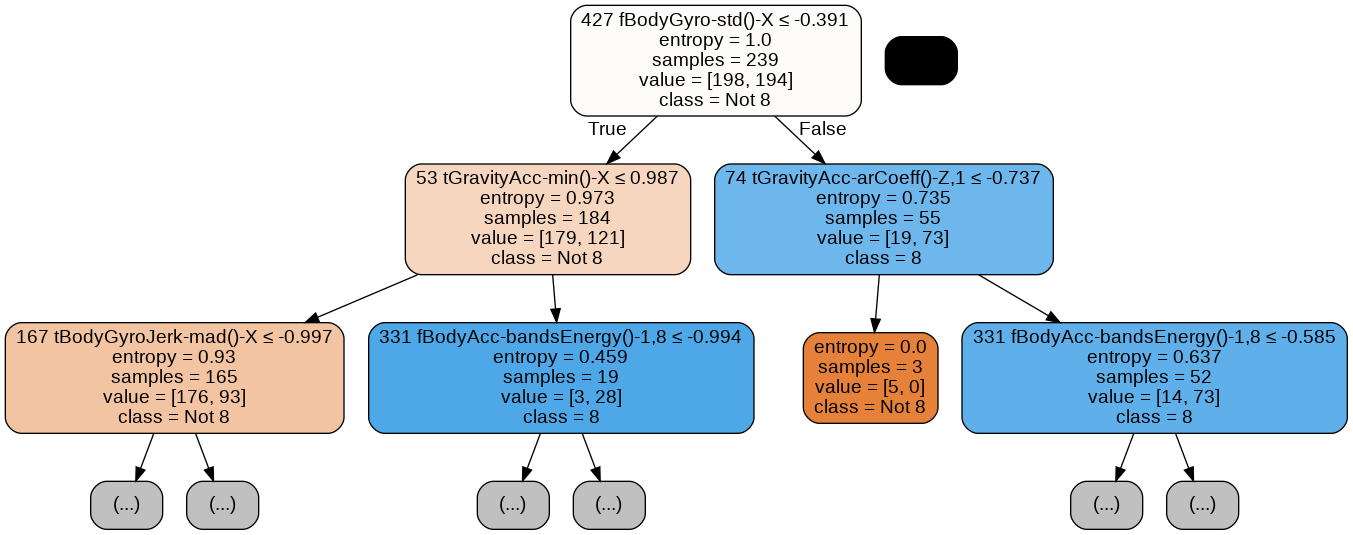

In [68]:
dot_data = tree.export_graphviz(rf_clf.estimators_[49], out_file=None,  
                                feature_names=features_to_keep, 
                                class_names=['Not {}'.format(target_class), str(target_class)],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=2)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

# Gradient Boosting

In [69]:
target_var = 'label'
target_class = 'WALKING_UPSTAIRS'
X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train, y_test = (rdf_train[target_var] == target_class).values, (rdf_test[target_var] == target_class).values

gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)

hgb_clf = HistGradientBoostingClassifier(learning_rate=1.0, max_depth=3, random_state=42)

xgb_clf = XGBClassifier(objective='binary:logistic', max_depth = 6, learning_rate = 1.0, gamma = 0.0, 
                        tree_method='exact', use_label_encoder=False, random_state=42)

lgbm_clf = LGBMClassifier(boosting_type='gbdt',  #'goss', #'dart'
                     max_depth=-1, # no limit
                     num_leaves=31,
                     n_estimators=100,
                     subsample_for_bin=200000,
                     objective='binary',
                     reg_alpha=0.0, #L1 regularization term on weights
                     reg_lambda=0.0, #L2 regularization term on weights
                     random_state=42)

classifiers = [gb_clf, hgb_clf, xgb_clf, lgbm_clf]

GradientBoostingClassifier: WALKING_UPSTAIRS
ROC AUC 0.9459246130153078
Accuracy 0.9273837801153716
F1-score [0.9570626  0.76483516]
              precision    recall  f1-score   support

       False       0.95      0.96      0.96      2476
        True       0.79      0.74      0.76       471

    accuracy                           0.93      2947
   macro avg       0.87      0.85      0.86      2947
weighted avg       0.93      0.93      0.93      2947

ROC_AUC Score 0.987 +/- 0.006 

########################

HistGradientBoostingClassifier: WALKING_UPSTAIRS
ROC AUC 0.9264600461671967
Accuracy 0.9239904988123515
F1-score [0.95469256 0.76421053]
              precision    recall  f1-score   support

       False       0.96      0.95      0.95      2476
        True       0.76      0.77      0.76       471

    accuracy                           0.92      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.92      0.92      0.92      2947

ROC_AUC Score 0.97

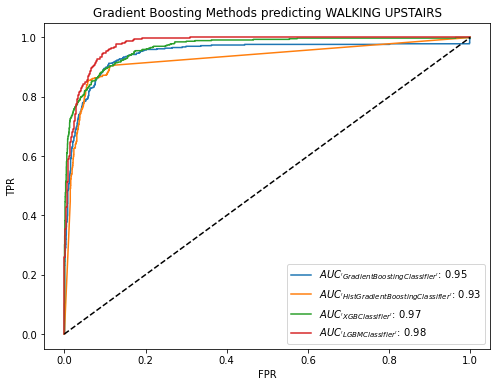

In [70]:
plt.figure(figsize=(8, 6))

for clf in classifiers:
    clf_name = str(clf)[:str(clf).find('(')]
    fpr, tpr, roc_auc = train_advanced(clf, target_class, X_train, X_test, y_train, y_test, scoring = 'roc_auc')
    plt.plot(fpr, tpr, label='$AUC_{clf}$: {roc_auc:.2f}'.format(clf={clf_name}, roc_auc=roc_auc))
    print('########################\n')
    
plt.plot([0,1], [0,1], 'k--')
plt.title('Gradient Boosting Methods predicting {}'.format(str(target_class).replace('_', ' ')))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

GradientBoostingClassifier: 8
ROC AUC 0.8316318041359638
Accuracy 0.958562641631596
F1-score [0.97862391 0.32631579]
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      3005
        True       0.29      0.37      0.33        84

    accuracy                           0.96      3089
   macro avg       0.64      0.67      0.65      3089
weighted avg       0.96      0.96      0.96      3089

ROC_AUC Score 0.841 +/- 0.047 

########################

HistGradientBoostingClassifier: 8
ROC AUC 0.6648898660961888
Accuracy 0.9592101003561023
F1-score [0.97905585 0.22222222]
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      3005
        True       0.23      0.21      0.22        84

    accuracy                           0.96      3089
   macro avg       0.60      0.60      0.60      3089
weighted avg       0.96      0.96      0.96      3089

ROC_AUC Score 0.682 +/- 0.065 

#################

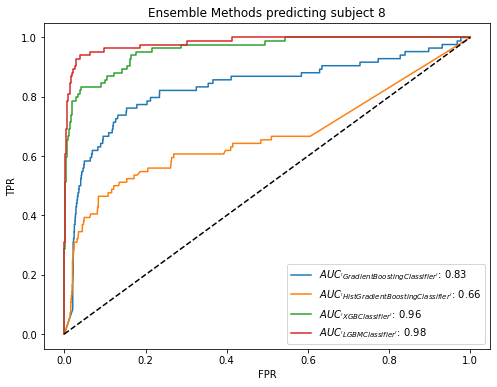

------------------Applying Undersampling------------------
GradientBoostingClassifier: 8
ROC AUC 0.9183305601774819
Accuracy 0.8284234380058271
F1-score [0.90356623 0.2228739 ]
              precision    recall  f1-score   support

       False       1.00      0.83      0.90      3005
        True       0.13      0.90      0.22        84

    accuracy                           0.83      3089
   macro avg       0.56      0.87      0.56      3089
weighted avg       0.97      0.83      0.89      3089

ROC_AUC Score 0.865 +/- 0.053 

########################

HistGradientBoostingClassifier: 8
ROC AUC 0.9118057206243562
Accuracy 0.8235674975720297
F1-score [0.90074668 0.20669578]
              precision    recall  f1-score   support

       False       0.99      0.82      0.90      3005
        True       0.12      0.85      0.21        84

    accuracy                           0.82      3089
   macro avg       0.56      0.83      0.55      3089
weighted avg       0.97      0.82      0.88 

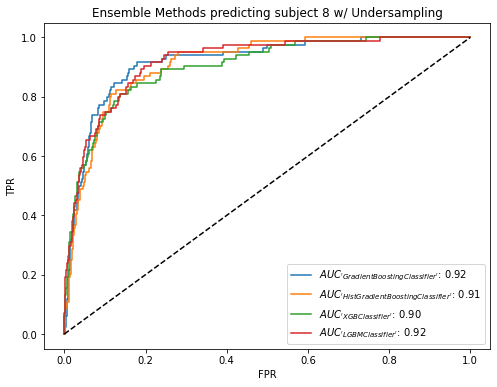

In [71]:
target_var = 'individuals'
target_class = min_performance[0]

X = rdf[features_to_keep].values
y = (rdf[target_var] == target_class).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

for description in [None, 'RUS']:
    rus_desc = ''
    if description == 'RUS':
        print('------------------Applying Undersampling------------------')
        X_train, y_train = rus.fit_resample(X_train, y_train)
        rus_desc = ' w/ Undersampling'
    
    plt.figure(figsize=(8, 6))

    for clf in classifiers:
        clf_name = str(clf)[:str(clf).find('(')]
        fpr, tpr, roc_auc = train_advanced(clf, target_class, X_train, X_test, y_train, y_test, scoring = 'roc_auc')
        plt.plot(fpr, tpr, label='$AUC_{clf}$: {roc_auc:.2f}'.format(clf={clf_name}, roc_auc=roc_auc))
        print('########################\n')
        
    plt.plot([0,1], [0,1], 'k--')
    plt.title('Ensemble Methods predicting subject {}{}'.format(target_class, rus_desc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

In [72]:
gbr = GradientBoostingRegressor(random_state=42)

num_x = 0
num_y = 4

X_train, X_test = rdf_train_val[:,num_x].reshape(-1, 1), rdf_test_val[:,num_x].reshape(-1, 1)
y_train, y_test = rdf_train_val[:,num_y], rdf_test_val[:,num_y]

gbr.fit(X_train, y_train)

print('\n#####################\n', gbr.train_score_)
print('\n#####################\n')

y_pred = gbr.predict(X_test)

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
print()



#####################
 [0.07145033 0.07038685 0.06949136 0.06876099 0.06806081 0.06754374
 0.06699686 0.06655354 0.06618675 0.0657685  0.06540706 0.0651172
 0.06478696 0.06464095 0.06444777 0.0642241  0.06404571 0.06392031
 0.063837   0.06374463 0.06368897 0.06351467 0.06344293 0.06337994
 0.06324614 0.06321032 0.06317695 0.06312535 0.06306438 0.06302768
 0.06289588 0.06286453 0.06283602 0.06277077 0.06274151 0.06262822
 0.06259854 0.06251872 0.06249603 0.0624427  0.06232444 0.06229892
 0.06228745 0.06222958 0.06215718 0.06212885 0.06202647 0.0619892
 0.06195585 0.06193899 0.06187629 0.06184468 0.06176295 0.06173058
 0.06172153 0.06165705 0.06159688 0.06157524 0.06154718 0.06152413
 0.0614532  0.06142742 0.06137336 0.06130301 0.0612911  0.06126799
 0.06121333 0.0611906  0.06111479 0.06106371 0.06098822 0.0609453
 0.06093834 0.06091181 0.06088617 0.06087431 0.06086262 0.0608165
 0.06076757 0.06073821 0.06066495 0.06065255 0.06063484 0.06061312
 0.06059237 0.06058028 0.0605555  0.060509

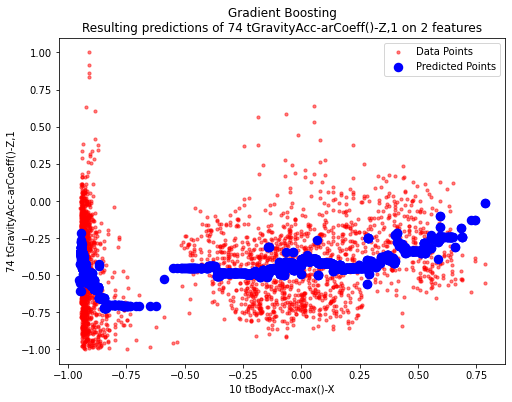

In [73]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test,  color='red', s=10, alpha=0.5, label='Data Points')
plt.scatter(X_test, y_pred, color='blue', linewidth=3.5, label='Predicted Points')
plt.xlabel(features_to_keep[num_x])
plt.ylabel(features_to_keep[num_y])
plt.title('Gradient Boosting\nResulting predictions of {} on 2 features'.format(features_to_keep[num_y]))
plt.legend()
plt.show()